# **XSPL Research Experience for High school students (REH)** 

### written by [Hannah Hasson](https://github.com/hrhasson/python-for-high-schoolers) (U of Rochester)  
&nbsp;  
## Using Fourier transforms to filter signals

We learned in the last notebook (Fourier_transforms.ipynb) how to take a Fourier transform on 1D (*np.fft.fft*) and 2D (*np.fft.fft2*) data in python. We also learned how to take the inverse transform (*ifft* and *ifft2*), getting the image back. Today we are going to do this same process, but we are going to modify the Fourier data before we transform back into the spatial data.

Effectively what we will do is cut out a section of frequencies in frequency space, then revert back to the data and observe that the frequencies we removed are gone! Let's get a move on:

&nbsp;

We will need the same three packages yet again: 

* [OpenCV](https://opencv-python-tutroals.readthedocs.io/en/latest/py_tutorials/py_gui/py_image_display/py_image_display.html) (cv2) for importing and manipulating images

* [Matplotlib](https://matplotlib.org/) for plotting/displaying things nicely

* [Numpy](https://numpy.org/doc/stable/user/tutorials_index.html), our old friend that we use to handle arrays

Let's import these all now

In [ ]:
import cv2
import matplotlib.pyplot as plt #the usual way we name this
import numpy as np #again, the usual way we name this

###1D Fourier filtering

Let's start with 1D. We will take the combination of 2 different sine waves that we demonstrated last time:

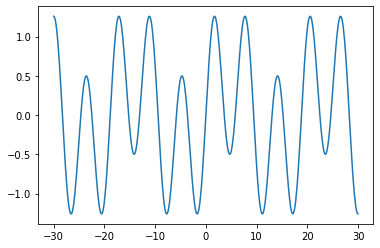

In [ ]:
def multi(x):
  y = np.sin(x)+ 0.5*np.sin(x/3)
  return y

xvals = np.linspace(-30,30,500)
multi_y = multi(xvals)

plt.plot(xvals, multi_y)

Let's look at it's Fourier transform again too:

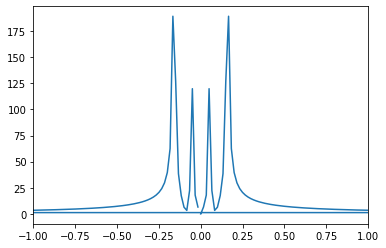

In [ ]:
#Take FFT, calculate frequency axis
multi_fft = np.fft.fft(multi_y)
freq = np.fft.fftfreq(xvals.shape[-1], d = (60/499)) #because our axis goes from -30 to 30 and has 500 values

#plot
plt.plot(freq, np.abs(multi_fft))
plt.xlim(-1,1)
plt.show()

So what if we wanted to remove one of the two frequencies present? It turns out that we can just remove that signal in the Fourier plane. Then, once we take the inverse transform back into the original axes, that frequency should be gone.

Let's try it! We will cut out the negative frequencies since they are redundant, and then cut out the lower freqency so we are only left with the peak on the far right.

&nbsp;

In order to make life a little easier, I am going to shift the order of the data so that the zero-frequency is in the center of the data. Just as we did with the 2D data, this is done with [np.fft.fftshift](https://numpy.org/doc/stable/reference/generated/numpy.fft.fftshift.html)

In [ ]:
#Shift the order of the data
multi_ffts =  np.fft.fftshift(multi_fft)
freq_shift = np.fft.fftshift(freq)

Let's set all the negative frequency info to zero and then check our work by plotting

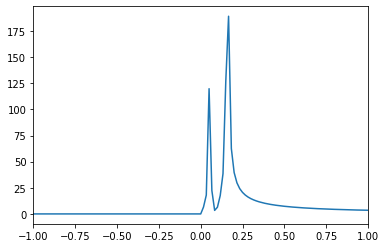

In [ ]:
#Find the index of the center element
multi_center = int(multi_ffts.size/2) #remember indeces are always integers

#Set all elements before the zero-frequency to zero
multi_ffts[:multi_center] = 0

#plot stuff
plt.plot(freq_shift, np.abs(multi_ffts))
plt.xlim(-1,1)
plt.show()

What we just did was called "masking!" This means we select a portion of our data to keep and then set the rest to zero.

Now I'm going to find the locations of the two remaining peaks and get rid of the leftmost one. I'm going to use a function called [scipy.signal.find_peaks](https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.find_peaks.html), which outputs the indeces of all peaks present. Don't forget, we must import its package first:

In [ ]:
import scipy.signal as s

peaks = s.find_peaks(np.abs(multi_ffts))[0] #take the zeroth index because the first output is the list of peaks
print(peaks)

[253 260]


Note that we had to use the find_peaks function on the *absolute value* of the Fourier data (since it's complex).

Now that we have the indexes of the two peaks, lets get rid of everything before the first peak. I'll add a couple indeces to make sure we get the width of the peak too:

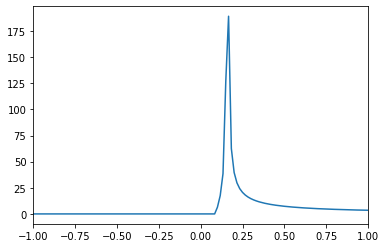

In [ ]:
#Set all elements before the first peak to zero
multi_ffts[:256] = 0

#plot stuff
plt.plot(freq_shift, np.abs(multi_ffts))
plt.xlim(-1,1)
plt.show()

Ta-da! Finally, let's shift the frequencies back to the order they were originally in [np.fft.ifftshift], and then do the inverse FFT [np.fft.ifft()](https://numpy.org/doc/stable/reference/generated/numpy.fft.ifft.html#numpy.fft.ifft)to get back the filtered signal.

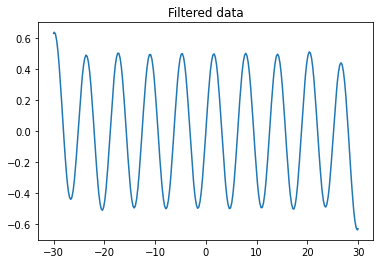

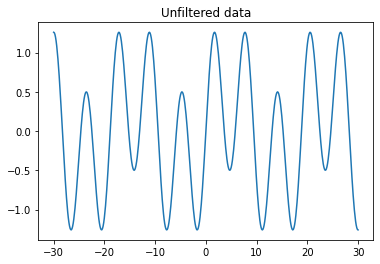

In [ ]:
#Un-shift the order of the data
multi_fft_filtered = np.fft.ifftshift(multi_ffts)

#Do the inverse FFT
multi_filtered = np.fft.ifft(multi_fft_filtered).real #we only want the real part when we revert back to the data

#plot the new filtered data
plt.plot(xvals, multi_filtered) 
plt.title("Filtered data")
plt.show()

#re-plot the old data for comparison
plt.plot(xvals, multi_y)
plt.title("Unfiltered data")
plt.show()

Et viola! It's certainly not perfect (the edges are funky), but we managed to get rid of the lower frequency in the original plot!

&nbsp;
###2D Fourier filtering

Now we're bringing out the big guns! **Let's do this on 2D data.** First we import the image just like last time. Make sure it's loaded into your "Files" tab (on the left) before running this cell.

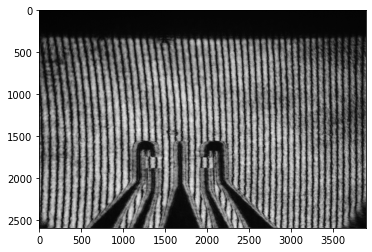

In [ ]:
# Load an color image in grayscale
img = cv2.imread('practice_image.jpg',0)
plt.imshow(img, cmap = 'gray')

Let's look at its **shifted** Fourier transform again

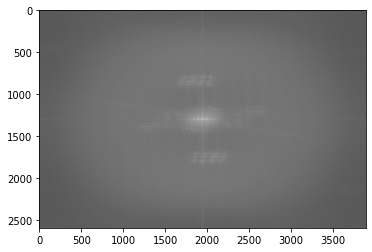

In [ ]:
#Take the 2D FFT of the image
img_fft = np.fft.fft2(img)

#Shift the order of the data so the zero-frequency is in the center
img_ffts =  np.fft.fftshift(img_fft)

#Plot
plt.imshow(np.log10(np.abs(img_ffts)), cmap = 'gray') #plot in log10 so it's easier to see

Now how would we filter this kind of data? Remember how I said that we made a **mask** by keeping some section of our data and setting the rest to zero? Well, we're doing that again but in 2D. This time we will be a little more clever though and use matrices.

&nbsp;

Let's say for this example that we want to keep a section in the top half that is 10% of the height and 10% of the full width. Here's how we would do that:

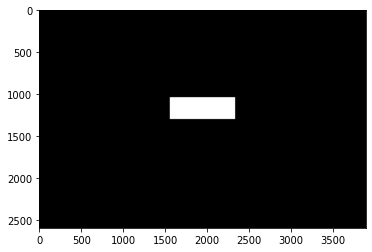

In [ ]:
# Define the fraction of coefficients (in each direction) we keep
keep_row = .1
keep_col = .1

# Get center columns and rows
rows, cols = img_ffts.shape #This is a really useful syntax
crow, ccol = int(rows/2) , int(cols/2)

# create a mask of zeroes first, set our rectangle = 1, leave all remaining as zeros
mask = np.zeros((rows,cols))
frow = int(crow-(rows*keep_row));#first row of mask
lrow = crow; #last row
fcol = int(ccol-(cols*keep_col)); #first column of mask
lcol = int(ccol+(cols*keep_col)); #last column

#Set the part of the mask we want to keep by indexing the bounds of the box
mask[frow:lrow, fcol:lcol] = 1

#Plot
plt.imshow(mask, cmap = 'gray')

So the rectangle we choose to keep is in white with a value of 1 at each point, and the data we are throwing out is in black with a value of 0 at each point. 

Let's now multiply every element of this matrix by the corresponding ones in the array of data.

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in log10
  """


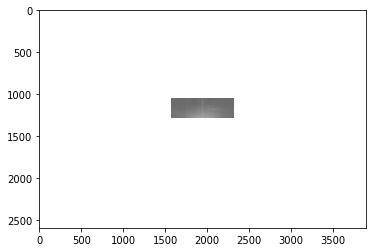

In [ ]:
#Multiply the mask by the data
img_ffts_filtered = img_ffts*mask

#Plot
plt.imshow(np.log10(np.abs(img_ffts_filtered)), cmap = 'gray') #plot in log10 so it's easier to see

There we have it! We got rid of all the stuff we don't want. Remember that the negative frequency data is redundant, so we don't need it. That's why everything below the x-axis is gone.

Finally, we can take the inverse 2D FFT of the data and see what image we get back:

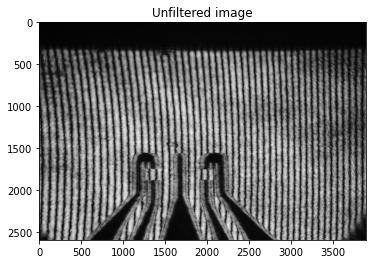

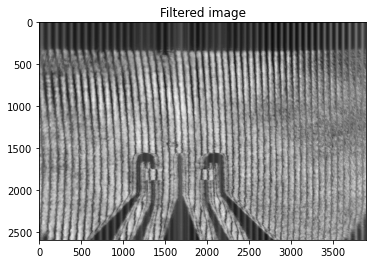

In [ ]:
#Un-shift the data before doing the IFFT
img_fft_filtered = np.fft.ifftshift(img_ffts_filtered)

#Take the 2D inverse FFT
img_filtered = np.fft.ifft2(img_fft_filtered).real #just keep the real part

#plot unfiltered data for comparison
plt.imshow(img, cmap = 'gray')
plt.title("Unfiltered image")
plt.show()

#Plot filtered data
plt.imshow(img_filtered, cmap = 'gray')
plt.title("Filtered image")
plt.show()

I realize that the difference might be a little subtle in this image. Try going back and altering the fractions of rows and columns to keep (keep_row, keep_col), as well as the position of the bottom of the box! You can also try just indexing arbitrary ranges of rows and columns to see what happens.

Finally, I want you to redo this process with one or both of the other sample images! Upload the image to this notebook and write your filtering code below:

In [ ]:
#Code here!



###Circular mask

Here is another function you can use to filter instead of the rectangle:

$f(x,y) = e^{-a[(x-b)^2+(y-c)^2]^2}$

Here's how you would apply it as a mask:

In [ ]:
#Define function for exponentially decaying circle
def filter(u,v,a,b,c):
  f = np.exp(-a*((u-b)**2+(v-c)**2)**2)
  return f

We're going to create a grid of points and then evaluate the function at every point. We can do this easily with a function called [numpy.meshgrid](https://numpy.org/doc/stable/reference/generated/numpy.meshgrid.html). 

For this example, we want to evaluate our function from $u$ and $v$ that range from [-1.25,1.25] and [-1,1] respectively. So we will create a matrix the same size as our image that has $u$ along the x-direction going smoothly from -1 to 1. And we will create another matrix storing our $v$ values that vary along y from -1 to 1. We are choosing that for this example because that's what they do in [this textbook](https://www.intechopen.com/books/optical-interferometry/digital-processing-techniques-for-fringe-analysis).

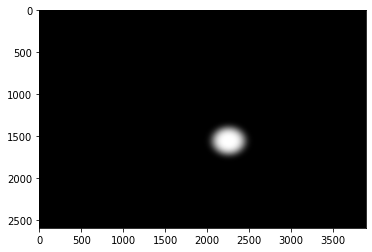

In [ ]:
#Create the meshgrid arrays for u and v
u, v = np.meshgrid(np.linspace(-1.25, 1.25, cols), np.linspace(-1, 1, rows))

#Evaluate the function at each point in the grid
circle_mask = filter(u,v,4000,0.2,0.2)

#Plot the mask we made
plt.imshow(circle_mask, cmap = 'gray')

You should try reproducing this, but playing with the inputs for a, b, c. Note that *a* controls the diameter of the circle, *b* controls the position of the circle in the x-direction, and *c* controls the position in the y-direction.

For example, if I now set a=500, b=0.2 and c=-0.6

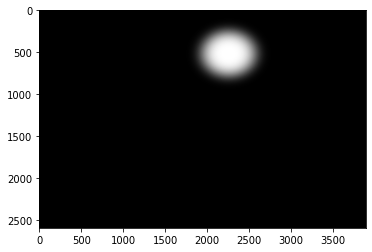

In [ ]:
#Evaluate the function at each point in the grid, choose new a,b and c
circle_mask = filter(u,v,500,0.2,-0.6)

#Plot the mask we made
plt.imshow(circle_mask, cmap = 'gray')

All that's left to do is multiply the mask by the image just as we did with the rectangle

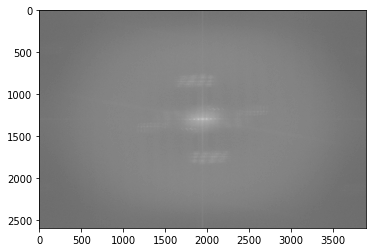

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in log10
  if __name__ == '__main__':


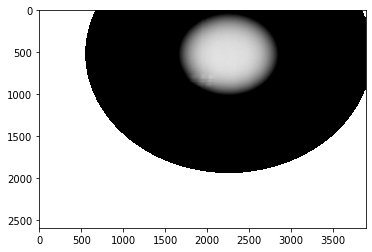

In [ ]:
#Multiply the mask by the data
img_ffts_circle = img_ffts*circle_mask

#Plot original FFT for comparison
plt.imshow(np.log10(np.abs(img_ffts)), cmap = 'gray')
plt.show()

#Plot filtered image
plt.imshow(np.log10(np.abs(img_ffts_circle)), cmap = 'gray',vmin= 0) #Use vmin=0 to make image easier to see
plt.show()

Looking at the filtered image in log10 can be a little confusing, but don't worry about the black part of the image. The area in the white circle is all that is really kept. So make sure that when you move the circle around, the white part encompasses the signal you want to keep.

&nbsp;

The rest of the process is exactly like in the above example (inverse shift Fourier transform and then take the inverse FFT). Try applying this filter to the image and moving the circle around/changing its size and see what effect that has on the frequencies filtered out.